In [1]:
import copy
import math
import tempfile
import json
import os
import glob
import soundfile
from pathlib import Path
from functools import partial
from datetime import datetime
from ruamel.yaml import YAML
from joblib import Parallel, delayed

import torch
import torch.nn as nn
import numpy as np
import librosa
import pyworld as pw
from omegaconf import DictConfig, OmegaConf, open_dict

# NeMo's "core" package
import nemo
# NeMo's ASR collection
import nemo.collections.asr as nemo_asr
import numpy as np
import librosa
import pyworld as pw
from omegaconf import DictConfig, OmegaConf, open_dict

# NeMo's "core" package
import nemo
# NeMo's ASR collection
import nemo.collections.asr as nemo_asr

[NeMo W 2020-12-03 22:34:45 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-12-03 22:34:45 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-12-03 22:34:45 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-12-03 22:34:45 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-12-03 22:34:45 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

In [ ]:
!wget https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet5x5LS-En.nemo

In [2]:
paths = list(Path(f'./dump/lj/logmelspectrogram/norm/').glob('*/*-wave.npy'))
paths2audio_files = paths
path_ppg = {}

In [3]:
len(paths)

13100

In [8]:
#モデル読み込み
model = nemo_asr.models.EncDecCTCModel.restore_from('./QuartzNet15x5Base-En.nemo')

# model.encoderから最後のJasper BlockとReLUを削除
identity = nn.Identity()
encoder_modules = list(model.encoder._modules['encoder'].children())
encoder_modules = encoder_modules[:-1] # Remove last Japser Block
encoder_modules[-1]._modules['mout'] = identity
encoder_modules_seq = nn.Sequential(*encoder_modules)
model.encoder._modules['encoder'] = encoder_modules_seq

# この辺の変数の意味
#https://github.com/NVIDIA/NeMo/blob/f0378b10cdadc82752d70032bd80219e531519c0/nemo/collections/asr/modules/audio_preprocessing.py
model.preprocessor.featurizer.dither = 0.0 # ホワイトノイズディザリング
model.preprocessor.featurizer.pad_to = 0 # 時間次元の出力をこの値の倍数になるようpaddingする. 0ならpaddingなし

# Switch model to evaluation mode
# Work in tmp directory - will store manifest file there
device = 'cuda'
model.eval()
for path in paths:
    arr = np.load(path)
    input_signal = torch.Tensor(arr.reshape(1, -1)).to(device)
    length = torch.Tensor(np.array([len(arr)])).to(device)
    processed_signal, processed_signal_length = model.preprocessor(
        input_signal=input_signal, length=length,
    )
    encoded, _ = model.encoder(
            audio_signal=processed_signal.to(device), length=length
    )
    result = encoded.data.cpu().numpy()[0]
    path_ppg[path] = result

[NeMo I 2020-12-03 16:30:28 features:241] PADDING: 16
[NeMo I 2020-12-03 16:30:28 features:258] STFT using torch
[NeMo I 2020-12-03 16:30:28 modelPT:237] Model EncDecCTCModel was successfully restored from ./QuartzNet15x5Base-En.nemo.


[NeMo W 2020-12-03 16:30:28 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
      return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
    
[NeMo W 2020-12-03 16:30:28 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
      return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
    


In [4]:
import joblib
#joblib.dump(path_ppg, 'path_ppg_norm.dump')
path_ppg = joblib.load('path_ppg_norm.dump')

In [11]:
from scipy.io import wavfile
import pyworld as pw
import numpy as np
import matplotlib.pyplot as plt

path_f0 = {}
fs = 22050
for path in paths:
    # fs : sampling frequency, 音楽業界では44,100Hz
    # data : arrayの音声データが入る 
    data = np.load(path)

    # floatでないとworldは扱えない
    data = data.astype(np.float)

    _f0, _time = pw.dio(data, fs)    # 基本周波数の抽出
    f0 = pw.stonemask(data, _f0, _time, fs)  # 基本周波数の修正
    path_f0[path] = f0

In [5]:
#joblib.dump(path_f0, 'path_f0_norm.dump')
path_f0 = joblib.load('path_f0_norm.dump')

In [6]:
ppgs = [path_ppg[key] for key in list(path_ppg.keys())[::3]]
ppgs = np.concatenate(ppgs, 1)
ppgs = ppgs.T # (特徴量, 時間) -> (時間, 特徴量) 
ppgs.shape

(1983139, 512)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(ppgs)
joblib.dump(scaler, 'dump/lj/logmelspectrogram/org/meanvar.joblib')
joblib.dump(scaler, 'dump/lj/logmelspectrogram/norm/meanvar.joblib')

['dump/lj/logmelspectrogram/norm/meanvar.joblib']

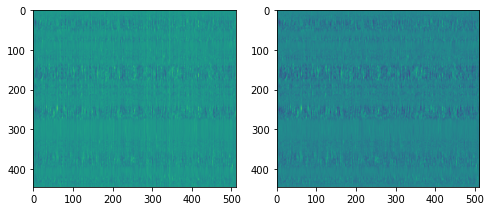

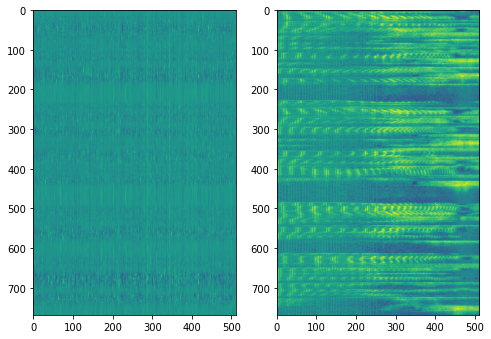

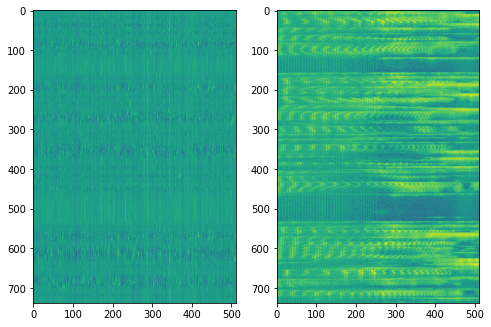

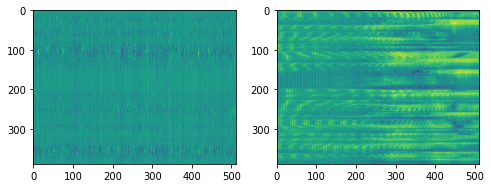

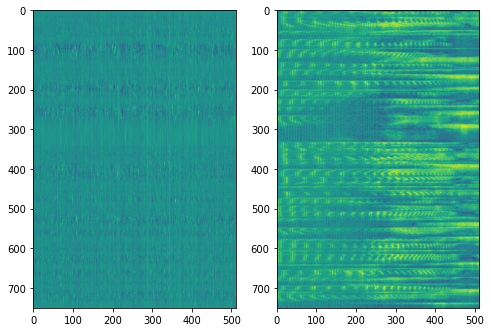

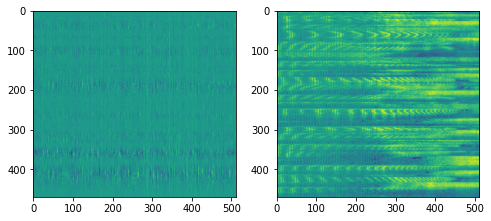

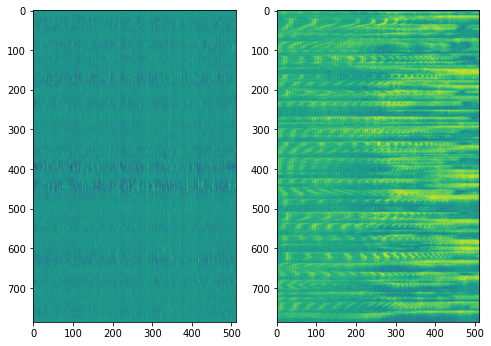

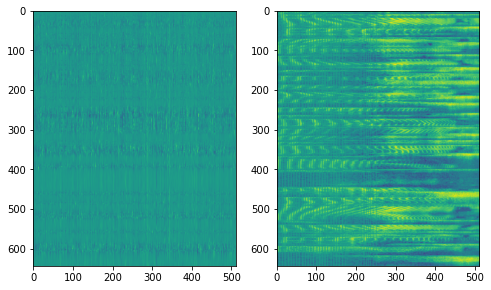

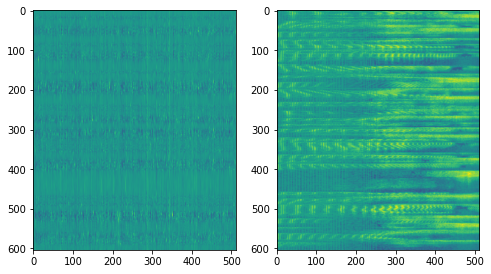

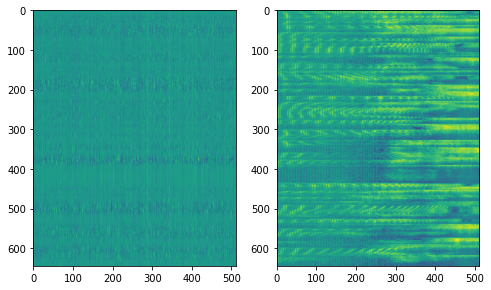

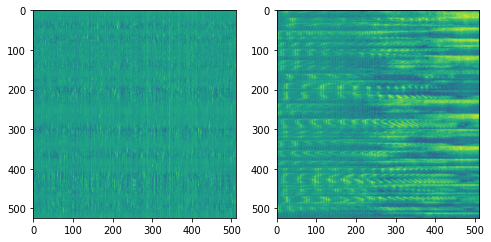

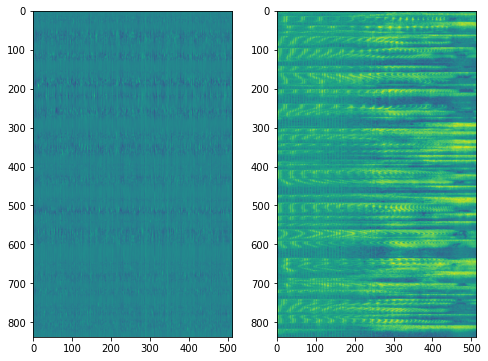

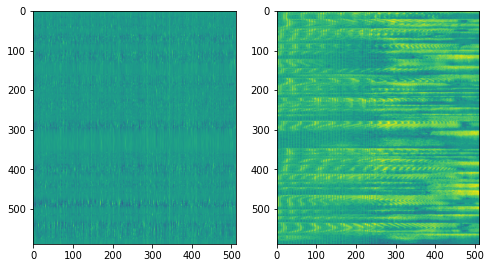

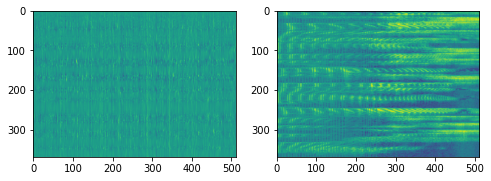

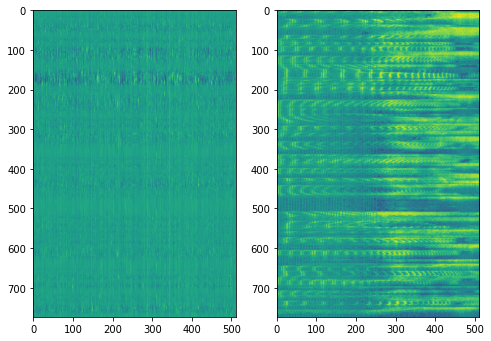

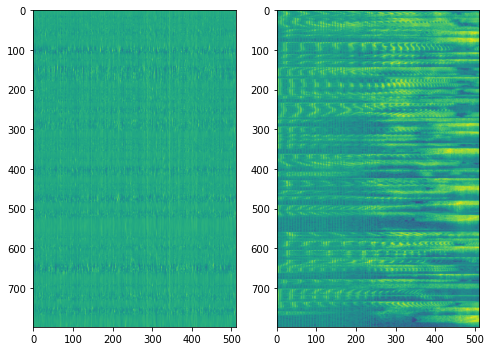

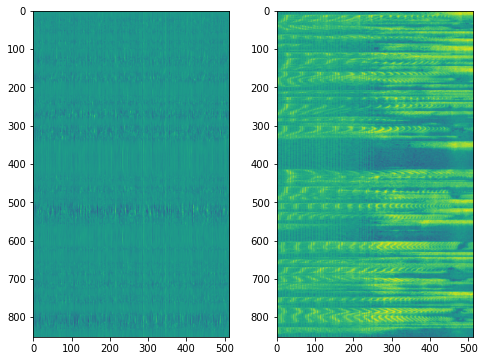

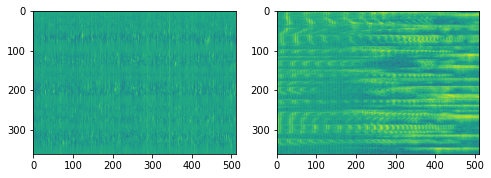

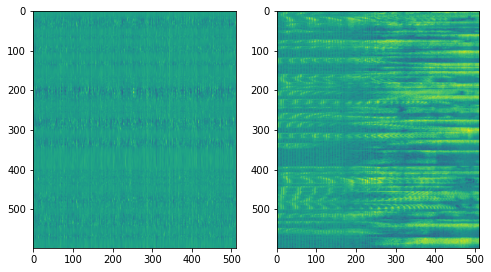

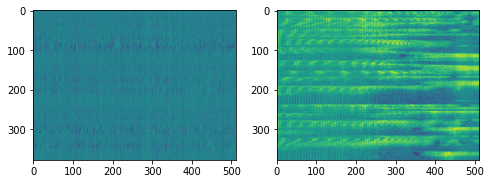

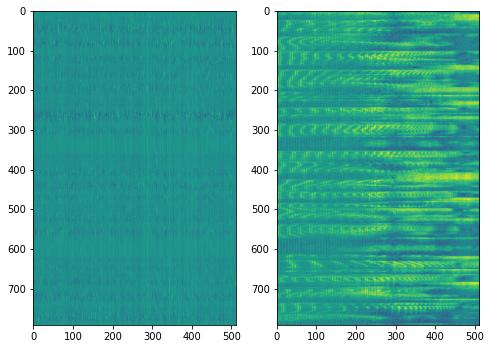

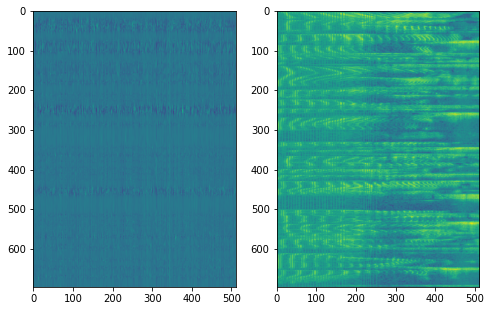

In [9]:
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
ratios = []
for i,  path in enumerate(path_ppg.keys()):
    ppg = path_ppg[path].T # (特徴量, 時間) -> (時間, 特徴量)
    f0 = path_f0[path]
    mel = np.load(str(path).replace('-wave.npy', '-feats.npy'))
    ppg_rows, ppg_cols = ppg.shape # rows: 時間 cols: 特徴量
    mel_rows, mel_cols = mel.shape # rows: 時間 cols: 特徴量
    
    zoomed_ppg = zoom(ppg, (mel_rows/ppg_rows, 1))
    zoomed_f0 = zoom(f0, (mel_rows / len(f0)))
    ratios.append(mel_rows/ppg_rows)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(zoomed_ppg)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(mel)
    plt.show()
    if i == 24:
        break

In [10]:
ratios # quartznetがsilent trimingなどしていればratiosはもっとバラけるはずだから,多分アラインメントには問題ない

[1.2492997198879552,
 1.2483766233766234,
 1.248730964467005,
 1.247588424437299,
 1.2495840266222962,
 1.246684350132626,
 1.2496025437201908,
 1.248062015503876,
 1.2479338842975207,
 1.2475822050290135,
 1.2478336221837087,
 1.2436548223350254,
 1.2487437185929648,
 1.2476190476190476,
 1.248882265275708,
 1.2484076433121019,
 1.2466216216216217,
 1.2483870967741935,
 1.2484375,
 1.249266862170088,
 1.2491349480968859,
 1.2484342379958246,
 1.2483443708609272,
 1.249211356466877,
 1.2495511669658887]

In [11]:
def get_save_feat(path):
    ppg = path_ppg[path].T # (特徴量, 時間) -> (時間, 特徴量)
    ppg = scaler.transform(ppg)
    f0 = path_f0[path]
    mel = np.load(str(path).replace('-wave.npy', '-feats.npy'))
    ppg_rows, ppg_cols = ppg.shape # rows: 時間 cols: 特徴量
    mel_rows, mel_cols = mel.shape # rows: 時間 cols: 特徴量
    
    zoomed_ppg = zoom(ppg, (mel_rows/ppg_rows, 1))
    zoomed_f0 = zoom(f0, (mel_rows / len(f0)))
    zoomed_f0 = np.maximum(zoomed_f0, 0) # F0は周波数なので必ず非負
    result = np.concatenate([zoomed_ppg[:, :511], np.expand_dims(zoomed_f0, 1)/100], 1) # 512番めの特徴量をF0/100に置換
    assert result.shape == mel.shape
    
    dst = str(path).replace('-wave.npy', '-feats.npy')
    np.save(dst, result)

In [12]:
for p in paths:
    get_save_feat(p)